In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
dir = '/content/gdrive/MyDrive/DSC 288R: Capstone Project/merge.csv'
df = pd.read_csv(dir)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18451 entries, 0 to 18450
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Year                                 18451 non-null  int64  
 1   Quarter                              18451 non-null  int64  
 2   Total_Mkt_Fare                       18451 non-null  float64
 3   depart_city                          18451 non-null  int64  
 4   arrival_city                         18451 non-null  int64  
 5   airlineID                            18451 non-null  int64  
 6   Passengers_by_Carrier                18451 non-null  int64  
 7   CarriersMktShare                     18451 non-null  float64
 8   CarrierAvgFare                       18451 non-null  float64
 9   Carrier_MinFareIncrement             18451 non-null  int64  
 10  CarrierMinPassangerShare             18451 non-null  float64
 11  CarrierMaxFareIncrement     

In [ ]:
X = df.loc[:, df.columns != 'Total_Mkt_Fare']
y = df.Total_Mkt_Fare

# make 30% test set and 70% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=21)

# devide test into half to form validation set: 25% test, 25% valid, 50% train
X_hold, X_valid, y_hold, y_valid = train_test_split(X_test, y_test, test_size=0.5,
                                                    random_state=21)

In [ ]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_hold.shape, y_hold.shape

((9225, 23), (9225,), (4613, 23), (4613,), (4613, 23), (4613,))

In [ ]:
# make dataframe to store results
results = pd.DataFrame(
    columns = ['Model', 'ori_RMSE_valid', 'ori_MAE_valid', 'ori_R2_valid',
               'tune_RMSE_valid', 'tune_MAE_valid', 'tune_R2_valid',
               'test_RMSE', 'test_MAE', 'test_R2'])

# **KNN Regressor**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=5)
knn = knn_model.fit(X_train, y_train)

## KNN Regression on Validation Set

In [ ]:
knn.score(X_valid, y_valid)

0.6678232832958764

In [ ]:
knn_preds_valid = knn.predict(X_valid)
knn_rmse_valid = np.sqrt(mean_squared_error(y_valid, knn_preds_valid))
knn_mae_valid = mean_absolute_error(y_valid, knn_preds_valid)
print(f'KNN Regression validation RMSE: {knn_rmse_valid}, MAE: {knn_mae_valid}')

KNN Regression validation RMSE: 51.18667389111693, MAE: 31.735580750054194


## Hypertuning/Parameters

In [ ]:
# Parameters for KNN Regressor
n_neighbors = range(1, 50)
weights = ['uniform', 'distance', None]
n_jobs = range(1, 11)

# Create the random grid
knn_random_grid = {'n_neighbors': n_neighbors,
               'weights': weights,
               'n_jobs': n_jobs}

In [ ]:
# Random search of parameters, using 10-fold cross validation,
# search across 10 different combinations, and use all available cores
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_random = RandomizedSearchCV(estimator = knn_model, param_distributions = knn_random_grid,
                               cv = 10, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
knn_random.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=KNeighborsRegressor(), n_jobs=-1,
                   param_distributions={'n_jobs': range(1, 11),
                                        'n_neighbors': range(1, 50),
                                        'weights': ['uniform', 'distance',
                                                    None]},
                   random_state=42, verbose=2)

In [ ]:
best_model_knn = knn_random.best_estimator_

# Print the best hyperparameters found
print("Best Hyperparameters for KNN Regression Random Search:\n", best_model_knn)

Best Hyperparameters for KNN Regression Random Search:
 KNeighborsRegressor(n_jobs=10, n_neighbors=46, weights='distance')


In [ ]:
# k-fold cross validation results
knn_random.cv_results_

{'mean_fit_time': array([0.01092715, 0.01338432, 0.01275105, 0.022299  , 0.02016418,
        0.01431193, 0.01369355, 0.01396253, 0.01931233, 0.013832  ]),
 'std_fit_time': array([0.00416997, 0.00749371, 0.00506798, 0.01086749, 0.00596145,
        0.00545065, 0.00958075, 0.00432624, 0.00893143, 0.00636279]),
 'mean_score_time': array([0.1912411 , 0.21770871, 0.20006692, 0.34474256, 0.34154675,
        0.20607998, 0.13894403, 0.19532969, 0.17335041, 0.17499764]),
 'std_score_time': array([0.0440237 , 0.05878803, 0.04700916, 0.06292805, 0.06129526,
        0.04920708, 0.03461587, 0.0469904 , 0.029111  , 0.03232186]),
 'param_weights': masked_array(data=['distance', 'distance', None, 'distance', None,
                    'uniform', 'uniform', 'distance', 'distance', None],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_n_neighbors': masked_array(data=[33, 46, 42, 40, 

## Tuned KNN Regression on Validation Set

In [ ]:
# Train the best model on the training data
best_model_knn.fit(X_train, y_train)

# Predictions on the validation set
knn_tune_preds_valid = best_model_knn.predict(X_valid)

# Evaluate the model on the validation set
knn_tune_rmse_valid = np.sqrt(mean_squared_error(y_valid, knn_tune_preds_valid))
knn_tune_mae_valid = mean_absolute_error(y_valid, knn_tune_preds_valid)

print(f'KNN Regression tuned validation RMSE: {knn_tune_rmse_valid}, MAE: {knn_tune_mae_valid}')

KNN Regression tuned validation RMSE: 45.994577031795615, MAE: 24.635605978127543


## Calculating the R^2 for the KNN Regression Model

In [ ]:
# Calculating R² on the validation set of original model
knn_r2_ori_valid = r2_score(y_valid, knn_preds_valid)

print(f'KNN Regression Validation R²: {knn_r2_ori_valid}')

# Calculating R² on the validation set of tuned model
knn_r2_tune_valid = r2_score(y_valid, knn_tune_preds_valid)

print(f'Tuned KNN Regression Validation R²: {knn_r2_tune_valid}')

KNN Regression Validation R²: 0.6678232832958764
Tuned KNN Regression Validation R²: 0.7317939149200787


## Tuned KNN Regression on Test Set

In [ ]:
# Predictions on the test set
knn_tune_preds_test = best_model_knn.predict(X_hold)

# Evaluate the model on the test set
knn_tune_rmse_test = np.sqrt(mean_squared_error(y_hold, knn_tune_preds_test))
knn_tune_mae_test = mean_absolute_error(y_hold, knn_tune_preds_test)

print(f'KNN Regression tuned test RMSE: {knn_tune_rmse_test}, MAE: {knn_tune_mae_test}')

# Calculating R² on the test set of tuned model
knn_r2_tune_test = r2_score(y_hold, knn_tune_preds_test)

print(f'Tuned KNN Regression Test R²: {knn_r2_tune_test}')

KNN Regression tuned test RMSE: 46.7861574600636, MAE: 25.140332204672823
Tuned KNN Regression Test R²: 0.7183485399629099


## Append Results to DataFrame

In [ ]:
results = results.append({'Model' : 'KNN Regression',
                          'ori_RMSE_valid': knn_rmse_valid,
                          'ori_MAE_valid': knn_mae_valid,
                          'ori_R2_valid': knn_r2_ori_valid,
                          'tune_RMSE_valid': knn_tune_rmse_valid,
                          'tune_MAE_valid': knn_tune_mae_valid,
                          'tune_R2_valid': knn_r2_tune_valid,
                          'test_RMSE': knn_tune_rmse_test,
                          'test_MAE': knn_tune_mae_test,
                          'test_R2': knn_r2_tune_test},
        ignore_index = True)

<ipython-input-17-4895e146b70d>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model' : 'KNN Regression',


## Test results - Plotted Accuracies

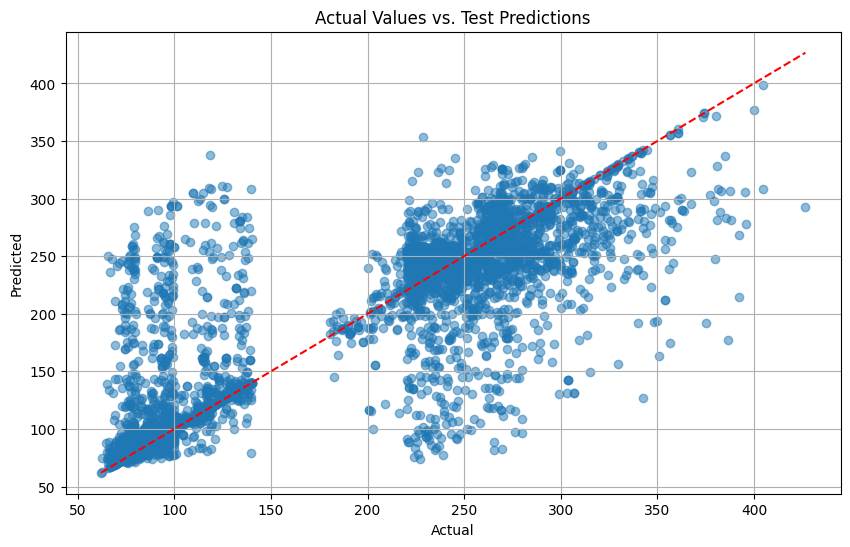

In [ ]:
# Plot test predictions against actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_hold, knn_tune_preds_test, alpha=0.5)
plt.plot([min(y_hold), max(y_hold)], [min(y_hold), max(y_hold)], linestyle='--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual Values vs. Test Predictions')
plt.grid(True)
plt.show()

# **Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
reg = lr_model.fit(X_train, y_train)

## Linear Regression on Validation Set

In [ ]:
reg.score(X_valid, y_valid)

0.9436419848072862

In [ ]:
reg_preds_valid = reg.predict(X_valid)
reg_rmse_valid = np.sqrt(mean_squared_error(y_valid, reg_preds_valid))
reg_mae_valid = mean_absolute_error(y_valid, reg_preds_valid)
print(f'Linear Regression validation RMSE: {reg_rmse_valid}, MAE: {reg_mae_valid}')

Linear Regression validation RMSE: 21.083861800121834, MAE: 13.488730548876314


## Hypertuning/Parameters

In [ ]:
# Parameters for Linear Regressor
fit_intercept = [True, False]
copy_X = [True, False]
n_jobs = range(1, 11)
positive = [True, False]

# Create the random grid
lr_random_grid = {'fit_intercept': fit_intercept,
               'copy_X': copy_X,
               'n_jobs': n_jobs,
               'positive': positive}

In [ ]:
# Random search of parameters, using 10-fold cross validation,
# search across 10 different combinations, and use all available cores
lr_model = LinearRegression()
reg_random = RandomizedSearchCV(estimator = lr_model, param_distributions = lr_random_grid,
                               cv = 10, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
reg_random.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=LinearRegression(), n_jobs=-1,
                   param_distributions={'copy_X': [True, False],
                                        'fit_intercept': [True, False],
                                        'n_jobs': range(1, 11),
                                        'positive': [True, False]},
                   random_state=42, verbose=2)

In [ ]:
best_model_reg = reg_random.best_estimator_

# Print the best hyperparameters found
print("Best Hyperparameters for Linear Regression Random Search:\n", best_model_reg)

Best Hyperparameters for Linear Regression Random Search:
 LinearRegression(fit_intercept=False, n_jobs=6)


In [ ]:
# k-fold cross validation results
reg_random.cv_results_

{'mean_fit_time': array([0.05998909, 0.06391513, 0.05570292, 0.04064374, 0.06585369,
        0.04514849, 0.04572015, 0.0608145 , 0.07457228, 0.0847218 ]),
 'std_fit_time': array([0.01861616, 0.01353628, 0.00809731, 0.01550848, 0.01999678,
        0.01573817, 0.01268185, 0.03114484, 0.01682296, 0.01487701]),
 'mean_score_time': array([0.00693364, 0.00751512, 0.01078072, 0.0049655 , 0.01488388,
        0.00649076, 0.00445669, 0.00713398, 0.01112661, 0.00814281]),
 'std_score_time': array([0.00322256, 0.00532975, 0.00452732, 0.00278191, 0.00761513,
        0.00505874, 0.00137376, 0.00494984, 0.00464644, 0.00481907]),
 'param_positive': masked_array(data=[True, True, True, False, True, True, True, True, True,
                    True],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_n_jobs': masked_array(data=[6, 1, 2, 6, 10, 5, 6, 6, 3, 7],
              mask=[False, 

## Tuned Linear Regression on Validation Set

In [ ]:
# Train the best model on the training data
best_model_reg.fit(X_train, y_train)

# Predictions on the validation set
reg_tune_preds_valid = best_model_reg.predict(X_valid)

# Evaluate the model on the validation set
reg_tune_rmse_valid = np.sqrt(mean_squared_error(y_valid, reg_tune_preds_valid))
reg_tune_mae_valid = mean_absolute_error(y_valid, reg_tune_preds_valid)

print(f'Linear Regression tuned validation RMSE: {reg_tune_rmse_valid}, MAE: {reg_tune_mae_valid}')

Linear Regression tuned validation RMSE: 21.09001962245125, MAE: 13.48237606998547


## Calculating the R^2 for the Linear Regression Model

In [ ]:
# Calculating R² on the validation set of original model
reg_r2_ori_valid = r2_score(y_valid, reg_preds_valid)

print(f'Linear Regression Validation R²: {reg_r2_ori_valid}')

# Calculating R² on the validation set of tuned model
reg_r2_tune_valid = r2_score(y_valid, reg_tune_preds_valid)

print(f'Tuned Linear Regression Validation R²: {reg_r2_tune_valid}')

Linear Regression Validation R²: 0.9436419848072862
Tuned Linear Regression Validation R²: 0.9436090597836927


## Tuned Linear Regression on Test Set

In [ ]:
# Predictions on the test set
reg_tune_preds_test = best_model_reg.predict(X_hold)

# Evaluate the model on the test set
reg_tune_rmse_test = np.sqrt(mean_squared_error(y_hold, reg_tune_preds_test))
reg_tune_mae_test = mean_absolute_error(y_hold, reg_tune_preds_test)

print(f'Linear Regression tuned test RMSE: {reg_tune_rmse_test}, MAE: {reg_tune_mae_test}')

# Calculating R² on the test set of tuned model
reg_r2_tune_test = r2_score(y_hold, reg_tune_preds_test)

print(f'Tuned Linear Regression Test R²: {reg_r2_tune_test}')

Linear Regression tuned test RMSE: 20.892607189396152, MAE: 13.408847254013079
Tuned Linear Regression Test R²: 0.9438354183098892


## Append Results to DataFrame

In [ ]:
results = results.append({'Model' : 'Linear Regression',
                          'ori_RMSE_valid': reg_rmse_valid,
                          'ori_MAE_valid': reg_mae_valid,
                          'ori_R2_valid': reg_r2_ori_valid,
                          'tune_RMSE_valid': reg_tune_rmse_valid,
                          'tune_MAE_valid': reg_tune_mae_valid,
                          'tune_R2_valid': reg_r2_tune_valid,
                          'test_RMSE': reg_tune_rmse_test,
                          'test_MAE': reg_tune_mae_test,
                          'test_R2': reg_r2_tune_test},
        ignore_index = True)

<ipython-input-29-2333c98528ff>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model' : 'Linear Regression',


## Test results - Plotted Accuracies

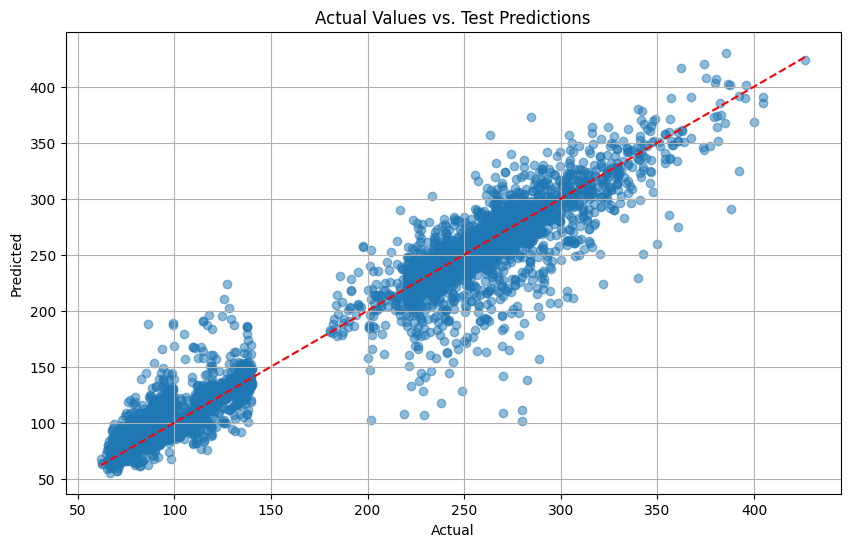

In [ ]:
# Plot test predictions against actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_hold, reg_tune_preds_test, alpha=0.5)
plt.plot([min(y_hold), max(y_hold)], [min(y_hold), max(y_hold)], linestyle='--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual Values vs. Test Predictions')
plt.grid(True)
plt.show()

# **Gradient Boosting Regressor**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor()
gbr = gb_model.fit(X_train, y_train)

## Gradient Boosting Regression on Validation Set

In [ ]:
gbr.score(X_valid, y_valid)

0.9697808109241561

In [ ]:
gbr_preds_valid = gbr.predict(X_valid)
gbr_rmse_valid = np.sqrt(mean_squared_error(y_valid, gbr_preds_valid))
gbr_mae_valid = mean_absolute_error(y_valid, gbr_preds_valid)
print(f'Gradient Boosting Regression validation RMSE: {gbr_rmse_valid}, MAE: {gbr_mae_valid}')

Gradient Boosting Regression validation RMSE: 15.438806317529618, MAE: 9.38155180059404


## Hypertuning/Parameters

In [ ]:
# Parameters for Gradient Boosting Regressor
loss = ['squared_error', 'absolute_error', 'huber', 'quantile']
learning_rate = np.arange(0.01, 0.5, 0.1)
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)]
max_depth = range(3, 7)
max_features = ['sqrt', 'log2', None]

# Create the random grid
gb_random_grid = {'loss': loss,
               'learning_rate': learning_rate,
               'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_features': max_features}

In [ ]:
# Random search of parameters, using 10-fold cross validation,
gb_model = GradientBoostingRegressor()
gbr_random = RandomizedSearchCV(estimator = gb_model, param_distributions = gb_random_grid,
                                cv = 10, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
gbr_random.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': array([0.01, 0.11, 0.21, 0.31, 0.41]),
                                        'loss': ['squared_error',
                                                 'absolute_error', 'huber',
                                                 'quantile'],
                                        'max_depth': range(3, 7),
                                        'max_features': ['sqrt', 'log2', None],
                                        'n_estimators': [50, 66, 83, 100, 116,
                                                         133, 150, 166, 183,
                                                         200]},
                   random_state=42, verbose=2)

In [ ]:
best_model_gbr = gbr_random.best_estimator_

# Print the best hyperparameters found
print("Best Hyperparameters for Gradient Boosting Regression Random Search:\n", best_model_gbr)

Best Hyperparameters for Gradient Boosting Regression Random Search:
 GradientBoostingRegressor(learning_rate=0.21000000000000002, loss='huber',
                          max_depth=6, max_features='sqrt', n_estimators=116)


In [ ]:
# k-fold cross validation results
gbr_random.cv_results_

{'mean_fit_time': array([3.42703855, 5.63688738, 4.26597502, 2.0451056 , 5.67363012,
        5.59379735, 6.75699587, 4.46539028, 2.67519231, 1.38091943]),
 'std_fit_time': array([1.17925296, 0.68053539, 0.71307663, 0.26877608, 0.87318662,
        1.75689537, 0.84366288, 0.65742133, 0.46711232, 0.36872392]),
 'mean_score_time': array([0.0054244 , 0.010675  , 0.00679209, 0.00843036, 0.01276903,
        0.01296852, 0.01146438, 0.00899844, 0.00841303, 0.00672343]),
 'std_score_time': array([0.00220137, 0.0040305 , 0.00312335, 0.00325586, 0.00824156,
        0.00417849, 0.00215932, 0.0001992 , 0.00374081, 0.00207469]),
 'param_n_estimators': masked_array(data=[50, 116, 50, 133, 183, 200, 150, 183, 50, 83],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[None, 'sqrt', None, 'log2', 'log2', 'sqrt', 'log2',
                    'sqrt', 'sqr

## Tuned Gradient Boosting Regression on Validation Set

In [ ]:
# Train the best model on the training data
best_model_gbr.fit(X_train, y_train)

# Predictions on the validation set
gbr_tune_preds_valid = best_model_gbr.predict(X_valid)

# Evaluate the model on the validation set
gbr_tune_rmse_valid = np.sqrt(mean_squared_error(y_valid, gbr_tune_preds_valid))
gbr_tune_mae_valid = mean_absolute_error(y_valid, gbr_tune_preds_valid)

print(f'Gradient Boosting Regression tuned validation RMSE: {gbr_tune_rmse_valid}, MAE: {gbr_tune_mae_valid}')

Gradient Boosting Regression tuned validation RMSE: 13.365499809228774, MAE: 7.4888397715274975


## Calculating the R^2 for the Gradient Boosting Regression Model

In [ ]:
# Calculating R² on the validation set of original model
gbr_r2_ori_valid = r2_score(y_valid, gbr_preds_valid)

print(f'KNN Regression Validation R²: {gbr_r2_ori_valid}')

# Calculating R² on the validation set of tuned model
gbr_r2_tune_valid = r2_score(y_valid, gbr_tune_preds_valid)

print(f'Tuned KNN Regression Validation R²: {gbr_r2_tune_valid}')

KNN Regression Validation R²: 0.9697808109241561
Tuned KNN Regression Validation R²: 0.9773522127758117


## Tuned Gradient Boosting Regression on Test Set

In [ ]:
# Predictions on the test set
gbr_tune_preds_test = best_model_gbr.predict(X_hold)

# Evaluate the model on the test set
gbr_tune_rmse_test = np.sqrt(mean_squared_error(y_hold, gbr_tune_preds_test))
gbr_tune_mae_test = mean_absolute_error(y_hold, gbr_tune_preds_test)

print(f'Gradient Boosting Regression tuned test RMSE: {gbr_tune_rmse_test}, MAE: {gbr_tune_mae_test}')

# Calculating R² on the test set of tuned model
gbr_r2_tune_test = r2_score(y_hold, gbr_tune_preds_test)

print(f'Tuned Gradient Boosting Regression Test R²: {gbr_r2_tune_test}')

Gradient Boosting Regression tuned test RMSE: 14.043472767159813, MAE: 7.653620585954473
Tuned Gradient Boosting Regression Test R²: 0.9746238178215343


## Append Results to DataFrame

In [ ]:
results = results.append({'Model' : 'Gradient Boosting Regression',
                          'ori_RMSE_valid': gbr_rmse_valid,
                          'ori_MAE_valid': gbr_mae_valid,
                          'ori_R2_valid': gbr_r2_ori_valid,
                          'tune_RMSE_valid': gbr_tune_rmse_valid,
                          'tune_MAE_valid': gbr_tune_mae_valid,
                          'tune_R2_valid': gbr_r2_tune_valid,
                          'test_RMSE': gbr_tune_rmse_test,
                          'test_MAE': gbr_tune_mae_test,
                          'test_R2': gbr_r2_tune_test},
        ignore_index = True)

<ipython-input-41-4ec851999ce7>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model' : 'Gradient Boosting Regression',


## Test results - Plotted Accuracies

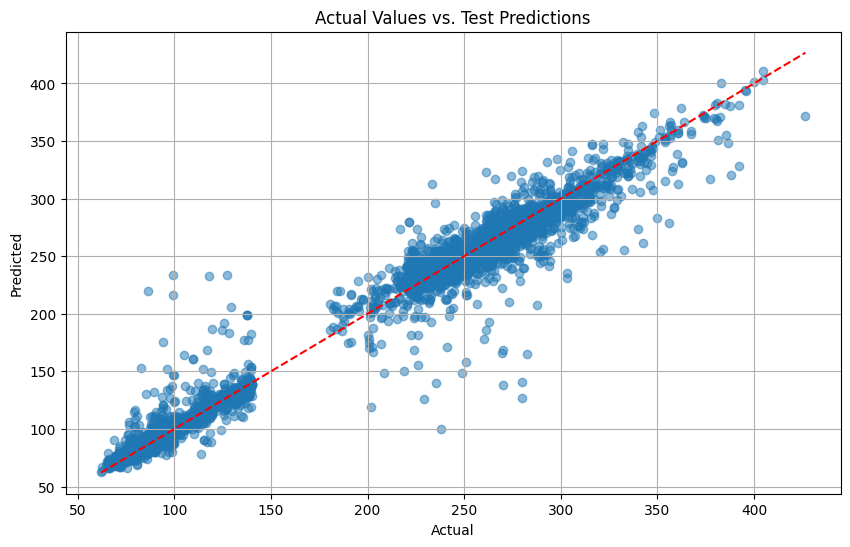

In [ ]:
# Plot test predictions against actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_hold, gbr_tune_preds_test, alpha=0.5)
plt.plot([min(y_hold), max(y_hold)], [min(y_hold), max(y_hold)], linestyle='--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual Values vs. Test Predictions')
plt.grid(True)
plt.show()

# **Random Forest Regressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rfr = rf_model.fit(X_train, y_train)

## Random Forest Regression on Validation Set

In [ ]:
rfr.score(X_valid, y_valid)

0.9785642478441767

In [ ]:
rfr_preds_valid = rfr.predict(X_valid)
rfr_rmse_valid = np.sqrt(mean_squared_error(y_valid, rfr_preds_valid))
rfr_mae_valid = mean_absolute_error(y_valid, rfr_preds_valid)
print(f'Random Forest Regression validation RMSE: {rfr_rmse_valid}, MAE: {rfr_mae_valid}')

Random Forest Regression validation RMSE: 13.002943619414017, MAE: 6.3531717754173


## Hypertuning/Parameters

In [ ]:
# Parameters for Gradient Boosting Regressor
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)]
max_depth = range(3, 7)
max_features = ['sqrt', 'log2', None]

# Create the random grid
rf_random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_features': max_features}

In [ ]:
# Random search of parameters, using 10-fold cross validation,
rf_model = RandomForestRegressor()
rfr_random = RandomizedSearchCV(estimator = gb_model, param_distributions = rf_random_grid,
                                cv = 10, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rfr_random.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': range(3, 7),
                                        'max_features': ['sqrt', 'log2', None],
                                        'n_estimators': [50, 66, 83, 100, 116,
                                                         133, 150, 166, 183,
                                                         200]},
                   random_state=42, verbose=2)

In [ ]:
best_model_rfr = rfr_random.best_estimator_

# Print the best hyperparameters found
print("Best Hyperparameters for Random Forest Regression Random Search:\n", best_model_gbr)

Best Hyperparameters for Random Forest Regression Random Search:
 GradientBoostingRegressor(learning_rate=0.21000000000000002, loss='huber',
                          max_depth=6, max_features='sqrt', n_estimators=116)


In [ ]:
# k-fold cross validation results
rfr_random.cv_results_

{'mean_fit_time': array([ 2.00084143,  2.52766666,  1.17642717, 10.38449717,  8.50741858,
         1.89163039,  1.94317536,  0.52010727,  0.92211022,  3.68703978]),
 'std_fit_time': array([0.74894651, 0.46582594, 0.01025587, 1.15245136, 0.73240525,
        0.07326622, 0.45310128, 0.01847952, 0.21759162, 0.54045125]),
 'mean_score_time': array([0.01414948, 0.01105633, 0.007184  , 0.0075001 , 0.00704422,
        0.00880489, 0.00812614, 0.00565805, 0.00910821, 0.01477582]),
 'std_score_time': array([0.01612477, 0.00519864, 0.0024332 , 0.00045321, 0.00068806,
        0.00215113, 0.00196758, 0.00230346, 0.00400381, 0.00522548]),
 'param_n_estimators': masked_array(data=[116, 166, 116, 133, 150, 116, 100, 50, 50, 166],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['log2', 'log2', 'sqrt', None, None, 'sqrt', 'log2',
                    

## Tuned Random Forest Regression on Validation Set

In [ ]:
# Train the best model on the training data
best_model_rfr.fit(X_train, y_train)

# Predictions on the validation set
rfr_tune_preds_valid = best_model_rfr.predict(X_valid)

# Evaluate the model on the validation set
rfr_tune_rmse_valid = np.sqrt(mean_squared_error(y_valid, rfr_tune_preds_valid))
rfr_tune_mae_valid = mean_absolute_error(y_valid, rfr_tune_preds_valid)

print(f'Random Forest Regression tuned validation RMSE: {rfr_tune_rmse_valid}, MAE: {rfr_tune_mae_valid}')

Random Forest Regression tuned validation RMSE: 12.74208868614515, MAE: 7.467683119791885


## Calculating the R^2 for the Random Forest Regression Model

In [ ]:
# Calculating R² on the validation set of original model
rfr_r2_ori_valid = r2_score(y_valid, rfr_preds_valid)

print(f'Random Forest Regression Validation R²: {rfr_r2_ori_valid}')

# Calculating R² on the validation set of tuned model
rfr_r2_tune_valid = r2_score(y_valid, rfr_tune_preds_valid)

print(f'Tuned Random Forest Regression Validation R²: {rfr_r2_tune_valid}')

Random Forest Regression Validation R²: 0.9785642478441767
Tuned Random Forest Regression Validation R²: 0.9794156757176229


## Tuned Random Forest Regression on Test Set

In [ ]:
# Predictions on the test set
rfr_tune_preds_test = best_model_rfr.predict(X_hold)

# Evaluate the model on the test set
rfr_tune_rmse_test = np.sqrt(mean_squared_error(y_hold, rfr_tune_preds_test))
rfr_tune_mae_test = mean_absolute_error(y_hold, rfr_tune_preds_test)

print(f'Random Forest Regression tuned test RMSE: {rfr_tune_rmse_test}, MAE: {rfr_tune_mae_test}')

# Calculating R² on the test set of tuned model
rfr_r2_tune_test = r2_score(y_hold, rfr_tune_preds_test)

print(f'Tuned Random Forest Regression Test R²: {rfr_r2_tune_test}')

Random Forest Regression tuned test RMSE: 12.9703963294858, MAE: 7.546762505528094
Tuned Random Forest Regression Test R²: 0.9783536964551276


## Append Results to DataFrame

In [ ]:
results = results.append({'Model' : 'Random Forest Regression',
                          'ori_RMSE_valid': rfr_rmse_valid,
                          'ori_MAE_valid': rfr_mae_valid,
                          'ori_R2_valid': rfr_r2_ori_valid,
                          'tune_RMSE_valid': rfr_tune_rmse_valid,
                          'tune_MAE_valid': rfr_tune_mae_valid,
                          'tune_R2_valid': rfr_r2_tune_valid,
                          'test_RMSE': rfr_tune_rmse_test,
                          'test_MAE': rfr_tune_mae_test,
                          'test_R2': rfr_r2_tune_test},
        ignore_index = True)

<ipython-input-53-bb5be3d24f23>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model' : 'Random Forest Regression',


## Test results - Plotted Accuracies

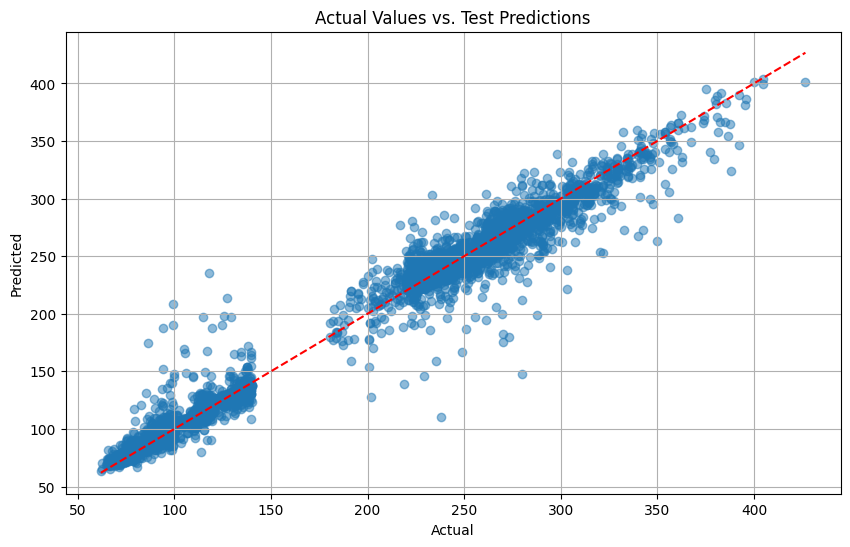

In [ ]:
# Plot test predictions against actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_hold, rfr_tune_preds_test, alpha=0.5)
plt.plot([min(y_hold), max(y_hold)], [min(y_hold), max(y_hold)], linestyle='--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual Values vs. Test Predictions')
plt.grid(True)
plt.show()

# **Results**

In [ ]:
# Compare results of models
results

,Model,ori_RMSE_valid,ori_MAE_valid,ori_R2_valid,tune_RMSE_valid,tune_MAE_valid,tune_R2_valid,test_RMSE,test_MAE,test_R2
0,KNN Regression,51.186674,31.735581,0.667823,45.994577,24.635606,0.731794,46.786157,25.140332,0.718349
1,Linear Regression,21.083862,13.488731,0.943642,21.090020,13.482376,0.943609,20.892607,13.408847,0.943835
2,Gradient Boosting Regression,15.438806,9.381552,0.969781,13.365500,7.488840,0.977352,14.043473,7.653621,0.974624
3,Random Forest Regression,13.002944,6.353172,0.978564,12.742089,7.467683,0.979416,12.970396,7.546763,0.978354


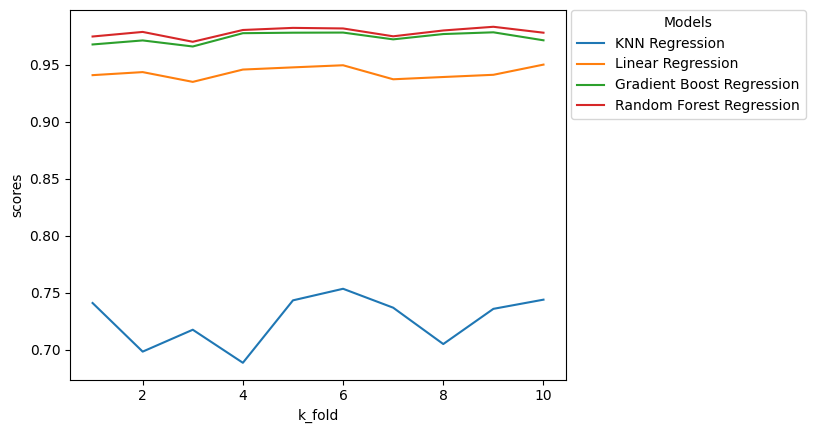

In [ ]:
# get k-fold cross validation scores
def get_cv_scores(model):
  i = model.best_index_
  results = model.cv_results_

  scores = []
  for j in range(10):
    scores.append(results[f'split{j}_test_score'][i])

  return scores

# Plot k-fold accuracies of tuned models
models = ['KNN Regression', 'Linear Regression',
          'Gradient Boost Regression', 'Random Forest Regression']
x = range(1, 11)

plt.plot(x, get_cv_scores(knn_random))
plt.plot(x, get_cv_scores(reg_random))
plt.plot(x, get_cv_scores(gbr_random))
plt.plot(x, get_cv_scores(rfr_random))
plt.xlabel('k_fold')
plt.ylabel('scores')
plt.legend(models, title='Models',
          bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

plt.show()

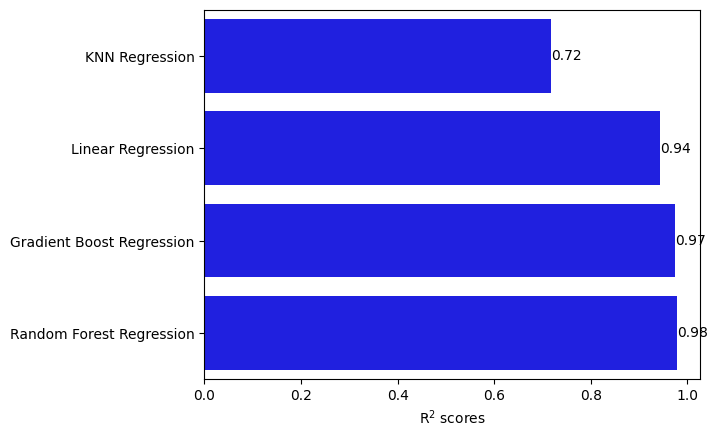

In [ ]:
# plot test r2 scores
scores = [knn_r2_tune_test, reg_r2_tune_test, gbr_r2_tune_test, rfr_r2_tune_test]
ax = sns.barplot(x=scores, y=models, orient='h', color='blue')
plt.xlabel('R$^2$ scores')
bars = ax.containers[0]
ax.bar_label(bars, labels=[f'{value:.2f}' for value in bars.datavalues])

plt.show()